# **Over-sampling:**
不均衡データのうち，少数派クラスのオーバーサンプリングを行います．<br>
以下の手法をここでは試しています．<br>
基本的には，SMOTEに対しての拡張版ということで様々な手法が提案されています．
- **SMOTE**
    - N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 16, 321-357, 2002.
- **ADASYN**
    - He, Haibo, Yang Bai, Edwardo A. Garcia, and Shutao Li. “ADASYN: Adaptive synthetic sampling approach for imbalanced learning,” In IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), pp. 1322-1328, 2008.

今回の主な目的は，Over-samplingやUnder-samplingの手法の理解になりますが，<br>
一応分類モデルを作成し，Over-samplingやUnder-samplingでどのように精度が変わるかを確認しています．

In [1]:
# ライブラリー
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import average_precision_score

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.ensemble import RandomForestClassifier

from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE, ADASYN

from visualize import viz_data

Using TensorFlow backend.


## **Dataset:**
不均衡データセットの作成<br>
over-sampling / under-samplingする前の不均衡データセットになります。

- 全サンプル数: 5500
- クラス数: 2
- クラス割合: positive(label=1):negative(label=0) = 1:10 = 500: 5000

In [2]:
def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}

def round_score(score):
    return np.round(score, 3)

In [3]:
# X, y = make_classification(
#     n_samples=9000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
#     weights=[0.99], flip_y=0, random_state=42
# )

X, y = make_moons(n_samples=10000, shuffle=True, noise=0.5, random_state=42)
X_imbalance, y_imbalance = make_imbalance(X, y, sampling_strategy=ratio_func(y, multiplier=0.1, minority_class=1))

data = {
    "feat1": X_imbalance[:, 0],
    "feat2": X_imbalance[:, 1],
    "target": y_imbalance
}
df = pd.DataFrame(data)

In [4]:
counter = Counter(y_imbalance)
print(counter)

Counter({0: 5000, 1: 500})


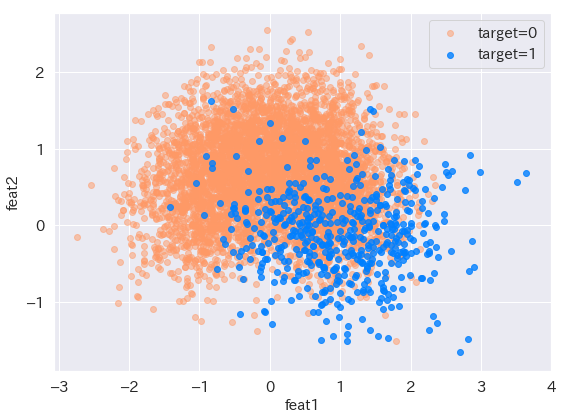

In [5]:
# sample dataset view
viz_data.plot_scatter(df)

### **ベースモデルによるAverage PRスコアの結果**
オリジナルの不均衡データに対して、RandomForestで分類した際の精度を計算
1. オリジナルの不均衡データを学習と評価に分割 (8:2)
2. バリデーションはStratifiedKFold (folds=5) を使用
3. モデルはRandomForestを使用
4. 最終的な評価はAverage precision-recall scoreを使用


ベースモデルのAverage PR-scoreかなり低いですね...

In [6]:
def cv_score(X_train, y_train, random_state=42):
    model = RandomForestClassifier(n_estimators=1000, max_depth=9, random_state=random_state)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    score_funcs = [
        'accuracy',
        'precision',
        'recall',
        'roc_auc'
    ]

    scores = cross_validate(model, X_train, y_train, scoring=score_funcs, cv=cv, return_estimator=True)
    print('Mean Accuracy:', round_score(scores['test_accuracy'].mean()))
    print('Mean Precision:', round_score(scores['test_precision'].mean()))
    print('Mean Recall:', round_score(scores['test_recall'].mean()))
    print('Mean ROC AUC:', round_score(scores['test_roc_auc'].mean()))
    
    return scores

def predict_mean_score(scores, X_test):
    pred_scores = []
    for i in range(len(scores['estimator'])):
        model = scores['estimator'][i]
        pred = model.predict_proba(X_test)
        pred_scores.append(pred)
    pred_score = np.mean(pred_scores, axis=0)
    
    return pred_score

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imbalance, y_imbalance, test_size=0.2, random_state=42, stratify=y_imbalance, shuffle=True
)

In [8]:
scores = cv_score(X_train, y_train, random_state=42)
pred_score = predict_mean_score(scores, X_test)
average_precision = average_precision_score(y_test, pred_score[:, 1])
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Mean Accuracy: 0.92
Mean Precision: 0.629
Mean Recall: 0.29
Mean ROC AUC: 0.884
Average precision-recall score: 0.58


## **SMOTE**
以下の図はSMOTEでのOver-samplingの方法を示したものになります．
<img src="./img/img1.png" width="800" height="600">

上記手続きは少数派クラス全てに対して行われます．<br>
また，最近傍点の数kはハイパーパラメータになり，kを大きくするとより遠くの点も考慮されることになります．

今回のOver-samplingでは，少数派クラスのデータを多数派のクラスの半分まで増やしました．<br>
minority sample: 400 --> 2000 (5倍に増えた)

SMOTEによりOver-samplingされたデータを緑色で示しています．

In [9]:
sm = SMOTE(sampling_strategy={1: 2000}, random_state=42, k_neighbors=5)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4000, 1: 2000})


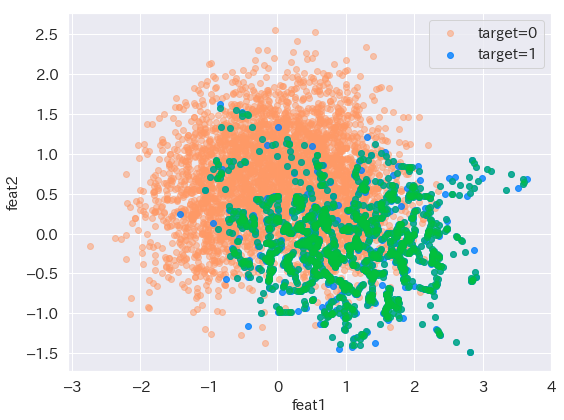

In [10]:
res_data = {
    "feat1": X_res[:, 0],
    "feat2": X_res[:, 1],
    "target": y_res
}
res_df = pd.DataFrame(res_data)
viz_data.plot_scatter(res_df, index=4400, both_plot=True)

### **SMOTEを行いデータを増やした結果**
Augumentationしたデータで再度学習し，評価データで予測した結果，Precision/Recallは上がりましたが，Average precision-recall scoreはむしろ悪くなっています．<br>
Recallがかなり良くなっているが，これはSMOTEによりpositiveクラスのデータが相対的に増えた影響があるかもしれない．

ROC AUCの値はSMOTE以前と比べるとよくなっているが，不均衡データのため，この指標で評価するのは難しい.

In [11]:
scores = cv_score(X_res, y_res, random_state=21)
pred_score = predict_mean_score(scores, X_test)
average_precision = average_precision_score(y_test, pred_score[:, 1])
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Mean Accuracy: 0.858
Mean Precision: 0.778
Mean Recall: 0.806
Mean ROC AUC: 0.927
Average precision-recall score: 0.57


## **ADASYN**
ADASYN...Adaptive synthetic samplingの略になります．<br>
ADASYNは，少数派サンプルをその分布に応じて生成するという考え方に基づいています．<br>
また，学習しにくい少数派クラスのサンプルの方が，学習しやすい少数派クラスのサンプルよりも多くの合成データが生成される.<br>
学習しにくい少数派クラスのサンプルとは，多数派クラスのサンプルとの境界付近のデータのことになります.<br>


In [12]:
ada = ADASYN(sampling_strategy={1: 2000}, random_state=42, n_neighbors=5)
X_res, y_res = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4000, 1: 2001})


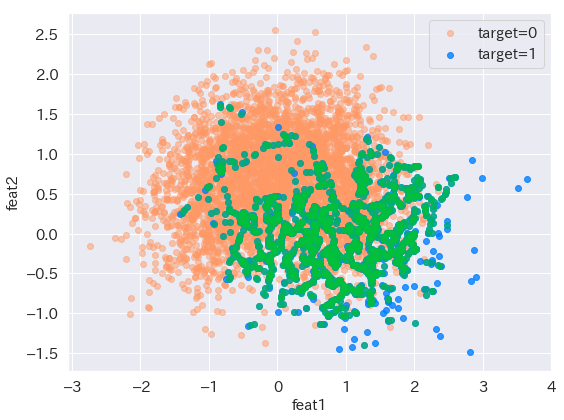

In [13]:
res_data = {
    "feat1": X_res[:, 0],
    "feat2": X_res[:, 1],
    "target": y_res
}
res_df = pd.DataFrame(res_data)
viz_data.plot_scatter(res_df, index=4400, both_plot=True)

### **ADASYNを行いデータを増やした結果**
Augumentationのされ方がSMOTEと比較した場合，多数派クラスのサンプルデータとの境界もしくは内部でより強くなっていることがわかる.

In [14]:
scores = cv_score(X_res, y_res, random_state=21)
pred_score = predict_mean_score(scores, X_test)
average_precision = average_precision_score(y_test, pred_score[:, 1])
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Mean Accuracy: 0.835
Mean Precision: 0.738
Mean Recall: 0.784
Mean ROC AUC: 0.906
Average precision-recall score: 0.55
